In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 9.5MB/s 
     |████████████████████████████████| 655kB 53.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/"

In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, tnrange

from torch.nn import CrossEntropyLoss, MSELoss
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score

import pandas as pd

from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""BERT finetuning runner."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file, quotechar=None):
        df = pd.read_csv(input_file,sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        return [sentences,aspectSentiment]
    
    @classmethod
    def _read_csv_augmented(cls, input_file, quotechar=None):
        df = pd.read_csv(input_file,sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        sentences, aspectSentiment = augmentationRound(sentences, aspectSentiment)
        return [sentences,aspectSentiment]
    
    @classmethod
    def _read_csv_augmented_from_file(cls, input_path, quotechar=None):
        df = pd.read_csv(input_path+"dataframePreProcessed.csv",sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        
        dfAugmented = pd.read_csv(input_path+"augmented.csv",sep='|')
        augmentedSentences = dfAugmented['Sentence'].values.tolist()
        augmentedAspects = dfAugmented['AspectSentiment'].values.tolist()
        
        return [sentences+augmentedSentences,aspectSentiment+augmentedAspects]

class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_csv_augmented_from_file(os.path.join(data_dir, "train/")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_csv(os.path.join(data_dir, "test/dataframePreProcessed.csv")), "test")

    def get_labels(self):
        """See base class."""
        all_labels = []
        #entities = ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'cg', 'gg']
        #attributes = ['g', 'p', 'll', 'h', 'e', 'c', 's', 'q', 'pp', 't', 'or', 'a', 'l', 'av']
        #sentiments = ['0','p','n']
        entities = ['organic', 'conventional', 'GMO']
        attributes = ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment']
        sentiments = ['0','p','n']
        for entity in entities:
            for attribute in attributes:
                for sentiment in sentiments:
                    all_labels.append(entity+'-'+attribute+'-'+sentiment)
        return all_labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i in range(len(lines[0])):
            guid = "%s-%s" % (set_type, i)
            text_a = lines[0][i]
            label = lines[1][i]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


def convert_examples_to_features(examples, label_list, max_seq_length,tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        # Get Label id
        label_id = label_map[example.label]

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels, average='binary'):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average=average)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }


def pearson_and_spearman(preds, labels):
    pearson_corr = pearsonr(preds, labels)[0]
    spearman_corr = spearmanr(preds, labels)[0]
    return {
        "pearson": pearson_corr,
        "spearmanr": spearman_corr,
        "corr": (pearson_corr + spearman_corr) / 2,
    }


def compute_metrics(preds, labels):
    assert len(preds) == len(labels)
    return {"acc": acc_and_f1(preds, labels, 'micro')}


In [0]:
def readConfig():
    args = argparse.Namespace()
    args.data_dir = sharedGFolderPath+'organic/annotated/data/'
    args.bert_model = 'bert-base-uncased'
    #args.pretrained_bert_model = sharedGFolderPath+'organic/unannotated/unsupervisedLM/Model/bert-uncased-pretrained-organic-V03/'
    args.pretrained_bert_model = sharedGFolderPath+'organic/annotated/baseline/model/baseline/'
    args.output_dir = sharedGFolderPath+'organic/annotated/baseline/model/Current/'
    args.max_seq_length = 32
    args.do_lower_case = True
    args.train_batch_size = 32
    args.eval_batch_size = 32
    args.learning_rate = 5e-5
    args.num_train_epochs = 3.0
    args.warmup_proportion = 0.1
    args.seed = 42
    
    return args

In [0]:
def runTraining(model,tokenizer,processor,device,args):
    train_trace, validation_trace = [], []

    logger.info("device: {}".format(device))

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    label_list = processor.get_labels()
    num_labels = len(label_list)

    train_examples = None
    num_train_optimization_steps = None
    train_examples = processor.get_train_examples(args.data_dir)
    num_train_optimization_steps = int(len(train_examples) / args.train_batch_size) * args.num_train_epochs
    
    model.to(device)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.1},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = BertAdam(optimizer_grouped_parameters, lr=args.learning_rate, warmup=args.warmup_proportion, t_total=num_train_optimization_steps)

    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    
    train_features = convert_examples_to_features(train_examples, label_list, args.max_seq_length, tokenizer)
    
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_examples))
    logger.info("  Batch size = %d", args.train_batch_size)
    logger.info("  Num steps = %d", num_train_optimization_steps)
    
    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=int(args.train_batch_size))

    for epochCount in tnrange(int(args.num_train_epochs), desc="Epoch"):
        # Set mode to Train
        model.train()
        
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        
        trainIterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(trainIterator):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            # define a new function to compute loss values
            logits = model(input_ids, segment_ids, input_mask, labels=None)

            # Compute Loss
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

            loss.backward()

            trainIterator.set_postfix(loss=loss.item())
            train_trace.append(loss.item())

            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            
            # Run optimizer
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
        # Get Validation performance on the current model
        if (epochCount==int(args.num_train_epochs)-1):
            validation_trace += runValidation(model,tokenizer,processor,device,args,True)
        else:
            validation_trace += runValidation(model,tokenizer,processor,device,args)

    # Save a trained model, configuration and tokenizer
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

    # If we save using the predefined names, we can load using `from_pretrained`
    output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
    output_config_file = os.path.join(args.output_dir, CONFIG_NAME)

    torch.save(model_to_save.state_dict(), output_model_file)
    model_to_save.config.to_json_file(output_config_file)
    tokenizer.save_vocabulary(args.output_dir)
    
    return train_trace, validation_trace

In [0]:
def runValidation(model,tokenizer,processor,device,args,shouldPrint=False):
    validation_trace = []
    
    # Run trained model on validation dataset
    label_list = processor.get_labels()
    num_labels = len(label_list)

    eval_examples = processor.get_dev_examples(args.data_dir)
    eval_features = convert_examples_to_features(eval_examples, label_list, args.max_seq_length, tokenizer)
    
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args.eval_batch_size)
    
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    model.to(device)
    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    validationIterator = tqdm_notebook(eval_dataloader, desc="Evaluating")
    for input_ids, input_mask, segment_ids, label_ids in validationIterator:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            logits = model(input_ids, segment_ids, input_mask, labels=None)

        # create eval loss and other metric required by the task
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
            
        batch_eval_loss = tmp_eval_loss.mean().item()
        validationIterator.set_postfix(loss=batch_eval_loss)
        validation_trace.append(batch_eval_loss)
        eval_loss += batch_eval_loss
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = preds[0]
    preds = np.argmax(preds, axis=1)

    if (shouldPrint==True):
        result = compute_metrics(preds, all_label_ids.numpy())
        result['eval_loss'] = eval_loss

        output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results *****")
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))
                
    logger.info("***** Finished evaluation *****")
                
    return preds, all_label_ids.numpy()

In [0]:
args = readConfig()
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)

processor = Sst2Processor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

#tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
tokenizer = BertTokenizer.from_pretrained(args.pretrained_bert_model, do_lower_case=args.do_lower_case)

# Prepare model
num_labels = len(processor.get_labels())
cache_dir = os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE))
#model = BertForSequenceClassification.from_pretrained(args.bert_model,cache_dir=cache_dir,num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(args.pretrained_bert_model,num_labels=num_labels)

07/29/2019 01:18:10 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file /content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/organic/annotated/baseline/model/baseline/vocab.txt
07/29/2019 01:18:10 - INFO - pytorch_pretrained_bert.modeling -   loading archive file /content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/organic/annotated/baseline/model/baseline/
07/29/2019 01:18:10 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [0]:
train_trace, validation_trace = runTraining(model,tokenizer,processor,device,args)

06/17/2019 00:25:36 - INFO - __main__ -   device: cuda
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
06/17/2019 00:25:41 - INFO - __main__ -   ***** Running training *****
06/17/2019 00:25:41 - INFO - __main__ -     Num examples = 18748
06/17/2019 00:25:41 - INFO - __main__ -     Batch size = 32
06/17/2019 00:25:41 - INFO - __main__ -     Num steps = 1755


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
06/17/2019 00:28:31 - INFO - __main__ -   ***** Running evaluation *****
06/17/2019 00:28:31 - INFO - __main__ -     Num examples = 414
06/17/2019 00:28:31 - INFO - __main__ -     Batch size = 32


06/17/2019 00:28:32 - INFO - __main__ -   ***** Finished evaluation *****


06/17/2019 00:31:22 - INFO - __main__ -   ***** Running evaluation *****
06/17/2019 00:31:22 - INFO - __main__ -     Num examples = 414
06/17/2019 00:31:22 - INFO - __main__ -     Batch size = 32


06/17/2019 00:31:23 - INFO - __main__ -   ***** Finished evaluation *****


06/17/2019 00:34:13 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
06/17/2019 00:34:13 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
06/17/2019 00:34:13 - INFO - __main__ -   ***** Running evaluation *****
06/17/2019 00:34:13 - INFO - __main__ -     Num examples = 414
06/17/2019 00:34:13 - INFO - __main__ -     Batch size = 32


06/17/2019 00:34:14 - INFO - __main__ -   ***** Eval results *****
06/17/2019 00:34:14 - INFO - __main__ -     acc = {'acc': 0.3502415458937198, 'f1': 0.3502415458937198, 'acc_and_f1': 0.3502415458937198}
06/17/2019 00:34:14 - INFO - __main__ -     eval_loss = 2.579015566752507
06/17/2019 00:34:14 - INFO - __main__ -   ***** Finished evaluation *****


In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

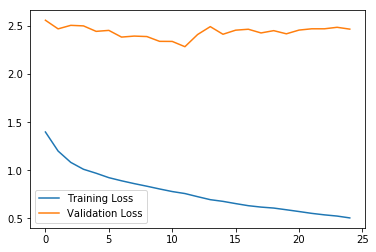

In [0]:
train_val_ratio = int(len(train_trace)/len(validation_trace))
train_loss = []
for i in range(len(validation_trace)):
    train_loss.append(np.mean(train_trace[i*train_val_ratio:(i+1)*train_val_ratio]))
plt.plot(running_mean(train_loss,15),label='Training Loss')
plt.plot(running_mean(validation_trace,15),label='Validation Loss')
plt.legend()
plt.show()

In [0]:
preds, labels = runValidation(model,tokenizer,processor,device,args,shouldPrint=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
07/29/2019 01:18:18 - INFO - __main__ -   ***** Running evaluation *****
07/29/2019 01:18:18 - INFO - __main__ -     Num examples = 460
07/29/2019 01:18:18 - INFO - __main__ -     Batch size = 32


07/29/2019 01:18:20 - INFO - __main__ -   ***** Eval results *****
07/29/2019 01:18:20 - INFO - __main__ -     acc = {'acc': 0.33695652173913043, 'f1': 0.33695652173913043, 'acc_and_f1': 0.33695652173913043}
07/29/2019 01:18:20 - INFO - __main__ -     eval_loss = 2.38573903242747
07/29/2019 01:18:20 - INFO - __main__ -   ***** Finished evaluation *****


In [0]:
def convert_label_id_to_label_val(label_list,pred_ids):
    label_map = {i : label for i, label in enumerate(label_list)}
    pred_labels = [label_map[pred_id] for pred_id in pred_ids]
    return pred_labels

In [0]:
preds, labels = convert_label_id_to_label_val(processor.get_labels(),preds), convert_label_id_to_label_val(processor.get_labels(),labels)

In [0]:
from sklearn.metrics import classification_report
import re
import seaborn as sns

In [0]:
cr = classification_report(labels,preds, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Joint Aspect-Sentiment classification performance')

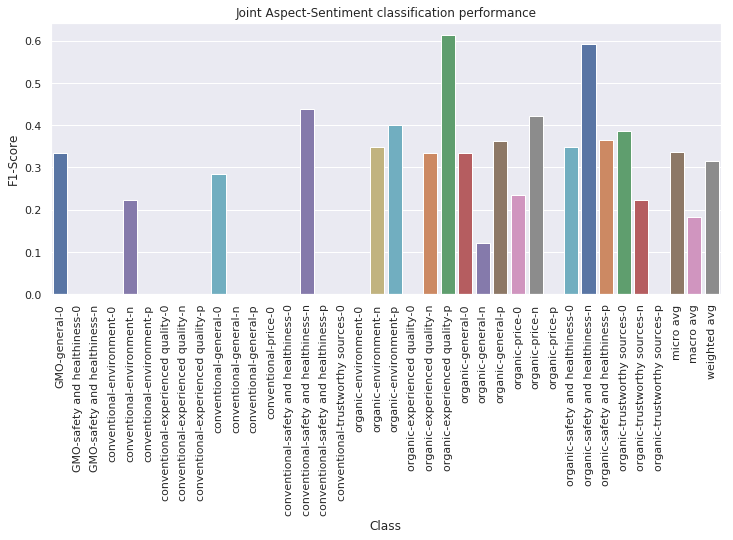

In [0]:
f1s = []
index = 0
for i,key in enumerate(cr.keys()):
    if (key == 'accuracy'):
        f1s.append(cr.get(key))
        index = i
    else:
        f1s.append(cr.get(key).get('f1-score'))

labels = list(cr.keys())
labels[index] = 'micro avg'
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(labels, f1s, palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Joint Aspect-Sentiment classification performance')

In [0]:
# FOR PRINTING PLOT OF CLASSIFICATION REPORT

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', shouldPrint=False):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    if (len(lines) > 100):
        return;

    plotMat = []
    support = []
    class_names = []
    report_data = []
    for line in lines[2 : (len(lines) - 2)]:
        t = re.split(r'\s{2,}', line.strip())
        if len(t) < 2:
            continue
        
        row = {}
        v = [float(x) for x in t[1: len(t) - 1]]
        if (len(v) > 1):
            row['precision'] = v[0]
            row['recall'] = v[1]
            row['f1_score'] = v[2]
            v = [v[2]]
            class_names.append(t[0])
            row['class'] = t[0]
        else:
            row['f1_score'] = v[0]
            row['class'] = 'micro avg'
            class_names.append('micro avg')
        support.append(int(t[-1]))
        row['support'] = int(t[-1])
        
        #print(v)
        plotMat.append(v)
        report_data.append(row)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))
    if shouldPrint:
        pd.DataFrame.from_dict(report_data).to_csv(os.path.join(args.save_dir, title+'.csv'), index = False)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 15
    figure_height = len(class_names)
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

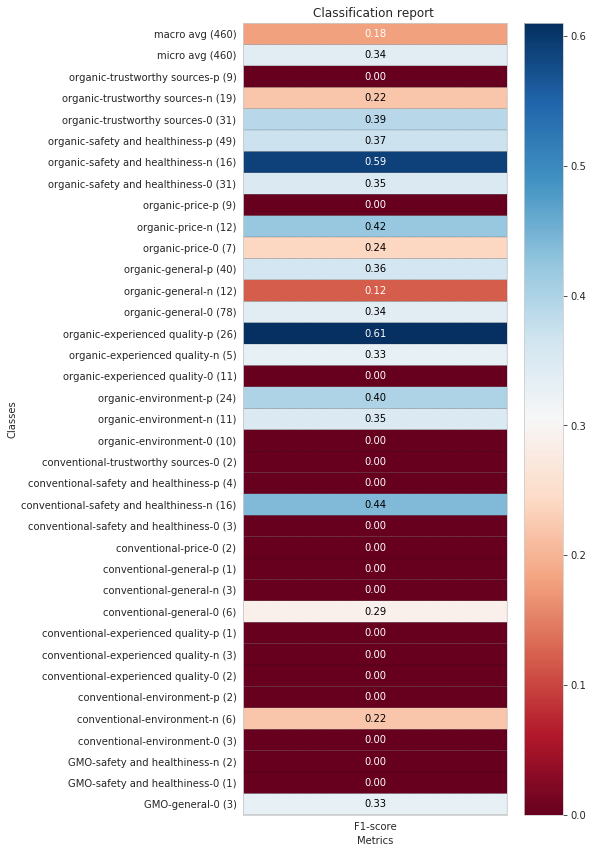

In [0]:
plot_classification_report(cr)